In [1]:
import pandas as pd
df_logins = pd.read_json('/logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
df_logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


### Part 1 - Exploratory data analysis

In [4]:
df_logins['login_count'] = 1
df_logins.set_index('login_time', inplace=True)
df_login_count = df_logins.resample('15T').sum()

In [5]:
import matplotlib.pyplot as plt
df_login_count.plot()

In [6]:
df_login_count['dayofweek'] = df_login_count.index.dayofweek
df_login_count.head()

,login_count,dayofweek
login_time,,
1970-01-01 20:00:00,2,3
1970-01-01 20:15:00,6,3
1970-01-01 20:30:00,9,3
1970-01-01 20:45:00,7,3
1970-01-01 21:00:00,1,3


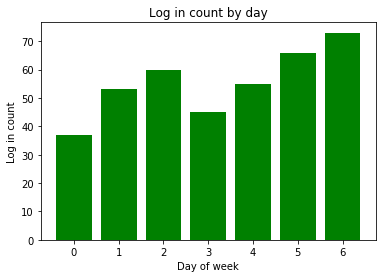

In [7]:
plt.bar(df_login_count['dayofweek'], df_login_count['login_count'], color='green')
plt.xlabel("Day of week")
plt.ylabel("Log in count")
plt.title("Log in count by day")

plt.show()

Based on 15 minute time interval log in count, it seems like more login occurs on weekends. 

### Part 2 - Experiment and metrics design

encourage driver partners to be available in both cities by reimbursing all toll costs

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would measure the number of times that a driver cross the bridge on weekends. If the number increases comparing to before the encouragement,I would say the reimbursement worked. The reason that I chose weekends is following. One is active during the day and the other is active. Therefore, even with the reimbursement, there might not be enough demand to cross the bridge. 

#### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success

###### how to implement the experiment
Before announcing bridge toll cost reimbursement program, the company needs to have data on how many times the drivers have been crossing bridge on weekends. The company makes the announcement, then start to collect the same measurement. 

###### statistical test to verify the significance of the observation
mu1: number of times that drivers crossed the bridge before reimbursement
mu2: number of times that drivers crossed the bridge after reimbursement

null hypothesis: mu2 >= mu1
Alternative: mu2 < mu1

With above hypothesis, I would do two tail test and measure p-value with alpha = 0.05.

###### how to interpret the result
If p-value is greater than 0.05, I would not reject null hypothesis which means the number of times that driver crossed bridge increased after reimbursement. 

### Part 3 - Predictive modeling

In [8]:
# dataset of cohort of users who signed up for an Ultimate account
# in January 2014
import json
with open('/ultimate_data_challenge.json') as f:
    data = json.load(f)

df_ultimate = pd.DataFrame(data)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [9]:
df_ultimate['avg_rating_by_driver'].fillna(0, inplace = True)
df_ultimate['avg_rating_of_driver'].fillna(0, inplace = True)
df_ultimate['phone'].fillna('unkown', inplace = True)

#Convert the time series to datetimes
df_ultimate.signup_date = pd.to_datetime(df_ultimate.signup_date)
df_ultimate.last_trip_date = pd.to_datetime(df_ultimate.last_trip_date)
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
df_ultimate[['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18 00:00:00,2014-06-29 00:00:00
freq,2948,2036
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-01-31 00:00:00,2014-07-01 00:00:00


In [11]:
# To find active users
for i in range(len(df_ultimate)): 
    # sign up date
    signup = df_ultimate['signup_date'][i]
    # last trip date
    last = df_ultimate['last_trip_date'][i]
    # will the user be active in their 6th month?
    testdate = signup + pd.Timedelta('181D')
    
    # preceding 30 days
    preceding = testdate - pd.Timedelta('30D')
    
    
    
    # see if the last trip date is with in preceding 30 days
    if preceding <= last <= testdate:
        df_ultimate.loc[i,'active'] = 1
    else:
        df_ultimate.loc[i,'active'] = 0

In [13]:
df_ultimate['active'].sum()

12198.0

##### A user is considered "retained" if they were "active" in the preceding 30 days
###### 1. What fraction of the observed users were retained?
Out of 50,000 users, 12198 users are considered as retained.
About 25% of users are retained users

In [16]:
# Changing categorical data into binary
ultimate = pd.get_dummies(df_ultimate)
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unkown
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0.0,0,1,0,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0.0,1,0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1.0,0,1,0,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0.0,0,0,1,1,0,0


In [25]:
from sklearn.model_selection import train_test_split
x = ultimate.drop(['active', 'last_trip_date', 'signup_date'], axis=1)
y = ultimate['active']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [26]:
# Random forest to see feature importance
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6706  888]
 [1336 1070]]
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      7594
         1.0       0.55      0.44      0.49      2406

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.69      0.66      0.67     10000
weighted avg       0.76      0.78      0.77     10000



In [28]:
feature_imp = pd.Series(clf.feature_importances_,index=x.columns).sort_values(ascending=False)
feature_imp

avg_dist                  0.303361
weekday_pct               0.148381
avg_rating_by_driver      0.103084
avg_rating_of_driver      0.093511
surge_pct                 0.093002
trips_in_first_30_days    0.089599
avg_surge                 0.076427
ultimate_black_user       0.023347
city_King's Landing       0.022010
phone_Android             0.013751
city_Astapor              0.012405
phone_iPhone              0.011824
city_Winterfell           0.008136
phone_unkown              0.001161
dtype: float64

###### What factors are the best predictors for retention

This random forest classifier model explains 77% of data. From the feature importance, the average distance in miles per trip taken in the first 30 days after signup is the most affecting factor to active user. The percent of the user's trips occurring during a weekday is the next most affecting factor. Since both indicates that the more user use the service, the more likely the user is going to be active. I would recommend them to have a marketing plan to attract those users. 